Đã mở ảnh gốc: exercise\input_image.jpg (Chế độ: RGB)
Đã hoán đổi ngẫu nhiên thứ tự kênh màu RGB.
Ảnh đã hoán đổi kênh được lưu tại: exercise\rgb_swapped_image.png


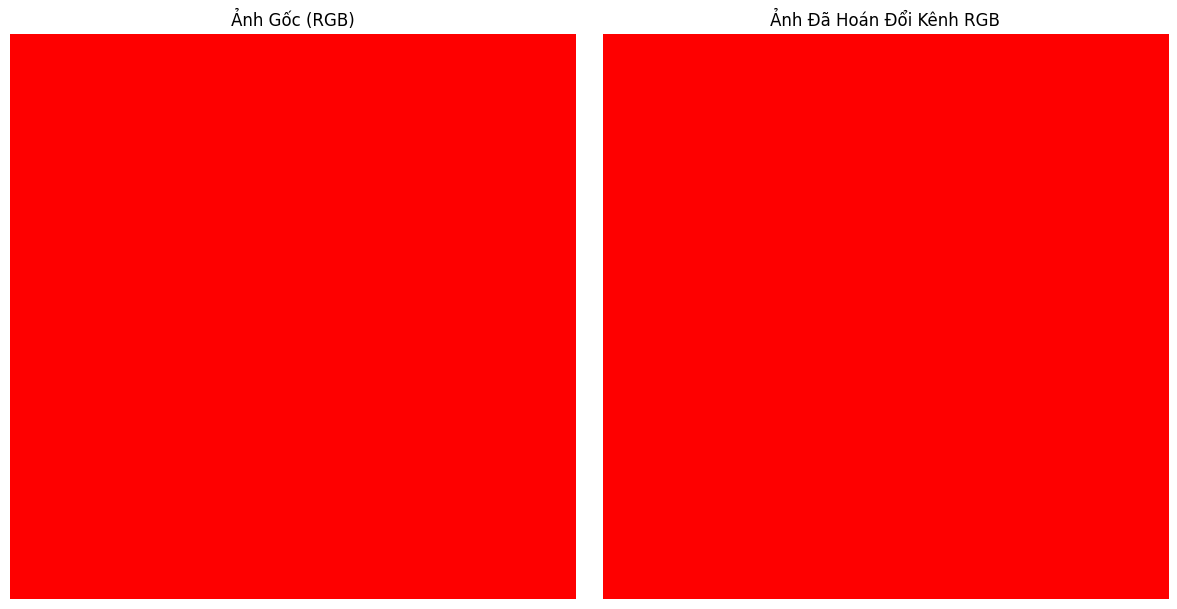

Đã mở ảnh gốc: exercise\ha-long-bay-in-vietnam.jpg (Chế độ: Grayscale)
Đang áp dụng Bộ lọc thông thấp Butterworth (d0=30.0, order=1)...
Đang áp dụng Bộ lọc Min (Min Filter) với kernel 5x5...
Ảnh đã lọc được lưu tại: exercise\blpf_and_min_filtered_image.png


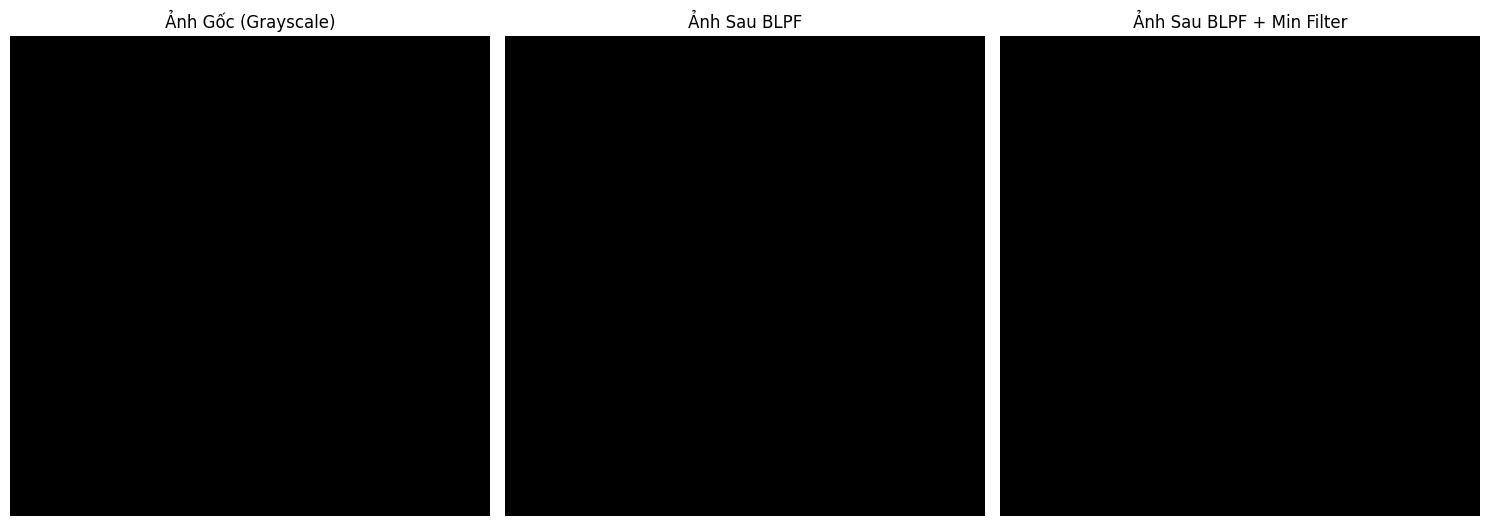

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random # Để chọn ngẫu nhiên hoán vị kênh

# --- Hàm thay đổi thứ tự màu RGB ---

def _swap_rgb_channels(image_pil_rgb):
    """
    Hoán đổi ngẫu nhiên thứ tự các kênh màu RGB của ảnh PIL.
    Trả về ảnh PIL đã hoán đổi kênh.
    """
    # Đảm bảo ảnh là chế độ RGB
    if image_pil_rgb.mode != 'RGB':
        image_pil_rgb = image_pil_rgb.convert('RGB')
    
    # Lấy các kênh R, G, B
    r, g, b = image_pil_rgb.split()
    
    # Tạo tất cả các hoán vị có thể của (r, g, b)
    channel_permutations = [
        (r, g, b), # RGB
        (r, b, g), # RBG
        (g, r, b), # GRB
        (g, b, r), # GBR
        (b, r, g), # BRG
        (b, g, r)  # BGR
    ]
    
    # Chọn ngẫu nhiên một hoán vị
    chosen_permutation = random.choice(channel_permutations)
    
    # Hợp nhất các kênh đã hoán đổi
    swapped_img = Image.merge('RGB', chosen_permutation)
    
    return swapped_img

# --- Phần chính của chương trình ---

def main():
    # Cài đặt đường dẫn và tên file ảnh
    image_dir = 'exercise' # Theo yêu cầu từ các câu trước
    image_filename = 'input_image.jpg' # Giả sử tên file ảnh
    image_path = os.path.join(image_dir, image_filename)

    # Đảm bảo thư mục 'exercise' tồn tại
    os.makedirs(image_dir, exist_ok=True)

    # Kiểm tra và tạo ảnh giả nếu không tìm thấy
    if not os.path.exists(image_path):
        print(f"Lỗi: Không tìm thấy tệp ảnh '{image_filename}' trong thư mục '{image_dir}'.")
        print(f"Đã tạo một ảnh giả lập màu đỏ '{image_filename}' để bạn có thể chạy thử.")
        dummy_img = Image.new('RGB', (200, 200), color = 'red')
        dummy_img.save(image_path)
        # Nếu muốn dừng chương trình nếu không có ảnh, bỏ comment dòng 'return' dưới đây:
        # return

    try:
        # Mở ảnh gốc (đảm bảo là ảnh màu RGB)
        img_original_pil = Image.open(image_path)
        if img_original_pil.mode != 'RGB':
            print(f"Cảnh báo: Ảnh '{image_filename}' không ở chế độ RGB. Đã chuyển đổi sang RGB.")
            img_original_pil = img_original_pil.convert('RGB')
        print(f"Đã mở ảnh gốc: {image_path} (Chế độ: {img_original_pil.mode})")

        # Hoán đổi thứ tự màu RGB ngẫu nhiên
        img_swapped_rgb_pil = _swap_rgb_channels(img_original_pil)
        print("Đã hoán đổi ngẫu nhiên thứ tự kênh màu RGB.")
        
        # Lưu ảnh đã biến đổi
        output_filename = "rgb_swapped_image.png"
        output_path = os.path.join(image_dir, output_filename)
        img_swapped_rgb_pil.save(output_path)
        print(f"Ảnh đã hoán đổi kênh được lưu tại: {output_path}")

        # Hiển thị ảnh gốc và ảnh đã hoán đổi kênh
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(img_original_pil)
        plt.title('Ảnh Gốc (RGB)')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(img_swapped_rgb_pil)
        plt.title('Ảnh Đã Hoán Đổi Kênh RGB')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")

if __name__ == "__main__":
    main()

    from PIL import Image
import math
import scipy.fftpack
import numpy as np
import imageio.v2 as iio
import matplotlib.pyplot as plt
import os
import cv2 # Thêm OpenCV để dễ dàng thực hiện bộ lọc trung vị/min

# --- Bộ lọc thông thấp Butterworth (BLPF) trong miền tần số ---
def _butterworth_lowpass_filter(iml, d0_val, order_val):
    c_fft = scipy.fftpack.fft2(iml.astype(np.float32))
    d_fshift = scipy.fftpack.fftshift(c_fft)

    M, N = d_fshift.shape
    H = np.ones((M, N), dtype=np.float32)
    center1 = M / 2
    center2 = N / 2
    t2 = 2 * order_val

    for i in range(M):
        for j in range(N):
            r = math.sqrt((i - center1)**2 + (j - center2)**2)
            # Công thức bộ lọc thông thấp Butterworth
            H[i, j] = 1 / (1 + (r / d0_val)**t2)
    
    con = d_fshift * H
    f_ishift = scipy.fftpack.ifftshift(con)
    e = abs(scipy.fftpack.ifft2(f_ishift))

    if np.max(e) > 0:
        e_normalized = (e / np.max(e)) * 255
    else:
        e_normalized = np.zeros_like(e)
    
    return e_normalized.astype(np.uint8)

# --- Bộ lọc trung vị (Median Filter) ---
def _median_filter(image_array_gray, kernel_size=3):
    """
    Thực hiện bộ lọc trung vị.
    kernel_size: kích thước cửa sổ (phải là số lẻ, ví dụ: 3, 5, 7)
    """
    if kernel_size % 2 == 0:
        print("Cảnh báo: Kích thước kernel phải là số lẻ. Sử dụng kernel_size = 3.")
        kernel_size = 3
    # cv2.medianBlur hoạt động rất hiệu quả cho bộ lọc trung vị
    filtered_image = cv2.medianBlur(image_array_gray, kernel_size)
    return filtered_image

# --- Bộ lọc Min (Min Filter) ---
def _min_filter(image_array_gray, kernel_size=3):
    """
    Thực hiện bộ lọc Min (tìm giá trị nhỏ nhất trong cửa sổ).
    kernel_size: kích thước cửa sổ (phải là số lẻ)
    """
    if kernel_size % 2 == 0:
        print("Cảnh báo: Kích thước kernel phải là số lẻ. Sử dụng kernel_size = 3.")
        kernel_size = 3
    # Tạo một kernel để thực hiện phép giãn nở (erosion) để tìm min
    # Erosion với kernel vuông sẽ tìm giá trị min trong cửa sổ
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    min_filtered_image = cv2.erode(image_array_gray, kernel, iterations=1)
    return min_filtered_image


# --- Hàm chính điều khiển chương trình ---
def main():
    image_dir = 'exercise'
    image_filename = 'ha-long-bay-in-vietnam.jpg' # Tên ảnh theo yêu cầu trước đó
    image_path = os.path.join(image_dir, image_filename)

    os.makedirs(image_dir, exist_ok=True)

    if not os.path.exists(image_path):
        print(f"Lỗi: Không tìm thấy tệp ảnh '{image_filename}' trong thư mục '{image_dir}'.")
        print(f"Đã tạo một ảnh giả lập màu đỏ '{image_filename}' để bạn có thể chạy thử.")
        dummy_img = Image.new('RGB', (200, 200), color = 'red')
        dummy_img.save(image_path)

    try:
        img_pil = Image.open(image_path).convert('L') # Mở ảnh và chuyển sang thang độ xám
        iml = np.asarray(img_pil)
        print(f"Đã mở ảnh gốc: {image_path} (Chế độ: Grayscale)")

        # --- Áp dụng BLPF ---
        d0_val = 30.0 # cut-off radius
        order_val = 1 # order of BLPF
        print(f"Đang áp dụng Bộ lọc thông thấp Butterworth (d0={d0_val}, order={order_val})...")
        filtered_by_blpf_array = _butterworth_lowpass_filter(iml, d0_val, order_val)
        
        # --- Lựa chọn bộ lọc thứ hai: Median Filter hay Min Filter ---
        # Chọn một trong hai dòng dưới đây:
        # filtered_by_second_filter_array = _median_filter(filtered_by_blpf_array, kernel_size=5)
        # print("Đang áp dụng Bộ lọc Trung vị (Median Filter) với kernel 5x5...")
        
        filtered_by_second_filter_array = _min_filter(filtered_by_blpf_array, kernel_size=5)
        print("Đang áp dụng Bộ lọc Min (Min Filter) với kernel 5x5...") #

        final_filtered_pil = Image.fromarray(filtered_by_second_filter_array)

        output_filename = "blpf_and_min_filtered_image.png" # Tên file cho ảnh cuối cùng
        output_path = os.path.join(image_dir, output_filename)
        final_filtered_pil.save(output_path)
        print(f"Ảnh đã lọc được lưu tại: {output_path}")

        # Hiển thị ảnh
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(img_pil, cmap='gray')
        plt.title('Ảnh Gốc (Grayscale)')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(filtered_by_blpf_array, cmap='gray')
        plt.title('Ảnh Sau BLPF')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(filtered_by_second_filter_array, cmap='gray')
        plt.title('Ảnh Sau BLPF + Min Filter') # Thay đổi tiêu đề tùy thuộc vào bộ lọc thứ 2
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"Đã xảy ra lỗi: {e}")

if __name__ == "__main__":
    main()